In [6]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch # entire library
import torch.nn as nn # all neural network moduals, e.g., linear, convolutional, loss function
import torch.optim as optim # optimization function
import torch.nn.functional as F # all functions that do not have parameters, e.g., Relu, Tanh, etc
from torch.utils.data import DataLoader # easier data management
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch.autograd import Function
from IPython import embed
import pandas.tseries.offsets as offsets
import torch
from statsmodels.tools.eval_measures import rmse
import torchvision.transforms as transforms

In [2]:
def mae(y,yh):
    return np.mean(np.abs(y-yh))

In [3]:
dftar1 = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS/Data_1/Firing1.xlsx",parse_dates=[1],index_col=1)
dftar2 = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS/Data_2/Firing2.xlsx",parse_dates=[1],index_col=1, skipfooter=1)
dftar3 = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/Firing/TrueValue.xlsx",parse_dates=[1],index_col=1)
dftar1 = dftar1.groupby(level=0).first()
dftar2 = dftar2.groupby(level=0).first()
dftar3 = dftar3.groupby(level=0).first()
y1 = dftar1.iloc[:,1].values
y2 = dftar2.iloc[:,1].values
y3 = dftar3.iloc[:,1].values
df1 = pd.read_hdf("C:/Users\liuwe\Desktop\Daily\Research\ENEOS/Data_1/8F_20190802_20200801_PV.hdf","df")
df2 = pd.read_hdf("C:/Users\liuwe\Desktop\Daily\Research\ENEOS/Data_2/8F_20201106_20210418_PV.hdf","xls_df")
df2[['R8FF22.PV','R8FF32.PV', 'R8FF5.PV']] = df2[['R8FF22.PV','R8FF32.PV', 'R8FF5.PV']].apply(pd.to_numeric, errors='coerce')
df3 = pd.read_hdf("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/Firing/8F_20210701_20210930_PV.hdf","xls_df")
dfext1 = pd.DataFrame(columns=df1.columns)
for i in range(len(dftar1.index)):
    dfext1.loc[dftar1.index[i]]=df1[dftar1.index[i]-offsets.Minute(60):dftar1.index[i]].mean()
dfext2 = pd.DataFrame(columns=df2.columns)
for i in range(len(dftar2.index)):
    dfext2.loc[dftar2.index[i]]=df2[dftar2.index[i]-offsets.Minute(60):dftar2.index[i]].mean()
dfext3 = pd.DataFrame(columns=df3.columns)
for i in range(len(dftar3.index)):
    dfext3.loc[dftar3.index[i]]=df3[dftar3.index[i]-offsets.Minute(60):dftar3.index[i]].mean()
    irq = dfext1.quantile(0.75)-dfext1.quantile(0.25)
vars_inactive = irq.index[irq==0.0]
dfext1 = dfext1.drop(vars_inactive,axis=1)
vars_hasnan = dfext1.columns[dfext1.isnull().sum(axis=0)>0]
dfext1 = dfext1.drop(vars_hasnan,axis=1)
dfext1 = dfext1.drop('8FHC2.OP',axis=1) # missing values
dfext2 = dfext2[dfext1.columns]
dfext3 = dfext3[dfext1.columns]
zero_column = dfext2.columns[(dfext2 == 0).sum(axis=0)>5]
dfext2[zero_column] = dfext2[zero_column].replace(0,dfext2[zero_column].mean())
nan_column = dfext2.columns[dfext2.isnull().sum(axis=0)>0]
dfext2[nan_column] = dfext2[nan_column].replace(np.nan,dfext2[nan_column].mean())
print(dfext1.shape)
print(dfext2.shape)
print(dfext3.shape)

(349, 118)
(141, 118)
(31, 118)


In [121]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(dfext1.values)
X_1 = scaler.transform(dfext1.values)
X_2 = scaler.transform(dfext2.values)
X_3 = scaler.transform(dfext3.values)

In [5]:
def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

def data_loader(X, y, batch_size, seed):
    X, y = torch.Tensor(X), torch.Tensor(y)
    data = TensorDataset(X, y)
    g = torch.Generator()
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker(seed), drop_last=False, generator=g)
    return data_loader

In [86]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_size=None, hidden_size=None, out_size=None):
        super(FeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        # self.fc2 = nn.Linear(in_features=hidden_size, out_features=out_size)
        # Define your architecture here

    def forward(self, x):
        # Forward pass through the feature extractor
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        return x

# Define the domain classifier
class DomainClassifier(nn.Module):
    def __init__(self,hidden_size):
        super(DomainClassifier, self).__init__()
        self.fc = nn.Linear(in_features=hidden_size, out_features=1)
        # Define your architecture here

    def forward(self, x):
        # Forward pass through the domain classifier
        x = torch.relu(self.fc(x))
        output = torch.sigmoid(x)
        return output

# Define the regression-specific output layer
class RegressionOutput(nn.Module):
    def __init__(self, out_size):
        super(RegressionOutput, self).__init__()
        self.fc_output = nn.Linear(in_features=out_size, out_features=1)
    
    def forward(self, x):
        return self.fc_output(x)


In [168]:
def regressor(num_epochs=None, input_size=None, hidden_size=None, out_size=None, lr=None,source_data_loader=None):
    feature_extractor = FeatureExtractor(input_size, hidden_size, out_size)
    reg = RegressionOutput(hidden_size)

    optimizer_fea = optim.Adam(feature_extractor.parameters(), lr=lr)
    optimizer_reg = optim.Adam(reg.parameters(), lr=lr)
    regression_criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        for source_x, source_y in source_data_loader:
            source_features = feature_extractor(source_x)
            predictions = reg(source_features)
            loss = regression_criterion(predictions, source_y)

            optimizer_fea.zero_grad()
            optimizer_reg.zero_grad()
            loss.backward()
            optimizer_fea.step()
            optimizer_reg.step()
        
        if epoch+1<10 or (epoch+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - loss: {loss:.4f}")
    
    return feature_extractor, reg

In [231]:
def Model_train(num_epochs=None, feature_ex=None,input_size=None, hidden_size=None, out_size=None, lr=None,source_data_loader=None, target_data_loader=None):    
    M_s = feature_ex # feature extractor trained from the source domain
    M_t = FeatureExtractor(input_size, hidden_size, out_size) # feature extractor for the target domain
    Discriminator = DomainClassifier(hidden_size) # Domain discriminator
    
    # Define the optimizer for the domain discriminator and the extractor of the target domain
    optimizer_d = optim.Adam(Discriminator.parameters(), lr=lr)
    optimizer_mt = optim.Adam(M_t.parameters(), lr=lr)
    
    # Loss functions
    domain_criterion = nn.BCEWithLogitsLoss()  # For domain classification
    
    # Training loop
    for epoch in range(num_epochs):
        for source_batch, target_batch in zip(source_data_loader, target_data_loader):
            source_x, source_y = source_batch
            target_x, target_y = target_batch

            # Feature extractor
            source_features = M_s(source_x)
            target_features = M_t(target_x)

            # Domain discriminator
            s_l = torch.ones(source_features.shape[0], 1)  # Labels for source domain (1s)
            t_l = torch.zeros(target_features.shape[0], 1)  # Labels for target domain (0s)
            domain_labels = torch.concatenate([s_l,t_l],0)
            domain_inputs = torch.concatenate([source_features, target_features],0)
            
            # Domain discriminator loss
            domain_predicts = Discriminator(domain_inputs)
            domain_loss = domain_criterion(domain_predicts, domain_labels)
          
            optimizer_d.zero_grad()
            domain_loss.backward()
            optimizer_d.step()

            # Target feature extractor loss
            optimizer_d.zero_grad()
            optimizer_mt.zero_grad()
            target_features = M_t(target_x)
            target_predicts = Discriminator(target_features)
            label_target = torch.ones(target_features.shape[0], 1)
            t_enc_loss = domain_criterion(target_predicts, label_target)
            t_enc_loss.backward()
            optimizer_mt.step()

            
        if epoch+1<10 or (epoch+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Domain Loss: {domain_loss:.4f} - Target Encoder Loss: {t_enc_loss:.4f}")
    
    return M_t

In [18]:
def Model_eva(feature_ex, reg, data_loader):
    feature_ex.eval()
    reg.eval()
    predictions = []
    with torch.no_grad():
        for x, y in data_loader:
            new_features = feature_ex(x)
            new_pred = reg(new_features)
            predictions = np.append(predictions, new_pred.detach().numpy().squeeze())
    return predictions

In [326]:
# source_data_loader = data_loader(X_1, y1.reshape((-1,1)), batch_size=30, seed=0)
# feature_ex_s, reg = regressor(num_epochs=10000, input_size=118, hidden_size=5, out_size=5, lr=0.001, source_data_loader=source_data_loader)

source_data_loader = data_loader(X_1, y1.reshape((-1,1)), batch_size=30, seed=0)
target_data_loader = data_loader(X_2, y2.reshape((-1,1)), batch_size=10, seed=0)
target2_data_loader = data_loader(X_3, y3.reshape((-1,1)), batch_size=5, seed=0)
feature_ex_t = Model_train(num_epochs=800, feature_ex=feature_ex_s, input_size=118, hidden_size=5, out_size=5, 
                           lr=0.0001, source_data_loader=source_data_loader,target_data_loader=target2_data_loader)


Epoch [1/800] - Domain Loss: 0.3346 - Target Encoder Loss: 0.4741
Epoch [2/800] - Domain Loss: 0.3346 - Target Encoder Loss: 0.4741
Epoch [3/800] - Domain Loss: 0.3346 - Target Encoder Loss: 0.4741
Epoch [4/800] - Domain Loss: 0.3346 - Target Encoder Loss: 0.4732
Epoch [5/800] - Domain Loss: 0.3348 - Target Encoder Loss: 0.4702
Epoch [6/800] - Domain Loss: 0.3350 - Target Encoder Loss: 0.4667
Epoch [7/800] - Domain Loss: 0.3352 - Target Encoder Loss: 0.4628
Epoch [8/800] - Domain Loss: 0.3354 - Target Encoder Loss: 0.4584
Epoch [9/800] - Domain Loss: 0.3357 - Target Encoder Loss: 0.4534
Epoch [100/800] - Domain Loss: 0.3447 - Target Encoder Loss: 0.3240
Epoch [200/800] - Domain Loss: 0.3452 - Target Encoder Loss: 0.3190
Epoch [300/800] - Domain Loss: 0.3457 - Target Encoder Loss: 0.3172
Epoch [400/800] - Domain Loss: 0.3459 - Target Encoder Loss: 0.3153
Epoch [500/800] - Domain Loss: 0.3457 - Target Encoder Loss: 0.3141
Epoch [600/800] - Domain Loss: 0.3457 - Target Encoder Loss: 0.313

In [327]:
ytrhat = Model_eva(feature_ex_s, reg, source_data_loader)
ytehat2 = Model_eva(feature_ex_t, reg, target_data_loader)
ytehat3 = Model_eva(feature_ex_t, reg, target2_data_loader)
print('Training RMSE:',rmse(y1,ytrhat))
print('Training MAE:', mae(y1,ytrhat))
print('Test2 RMSE:',rmse(y2,ytehat2))
print('Test2 MAE:',mae(y2,ytehat2))
print('Test3 RMSE:',rmse(y3,ytehat3))
print('Test3 MAE:',mae(y3,ytehat3))

Training RMSE: 0.6260441215051337
Training MAE: 0.5062220117082569
Test2 RMSE: 14.00796713078503
Test2 MAE: 9.552953909474907
Test3 RMSE: 5.091997712924708
Test3 MAE: 4.528494558026714


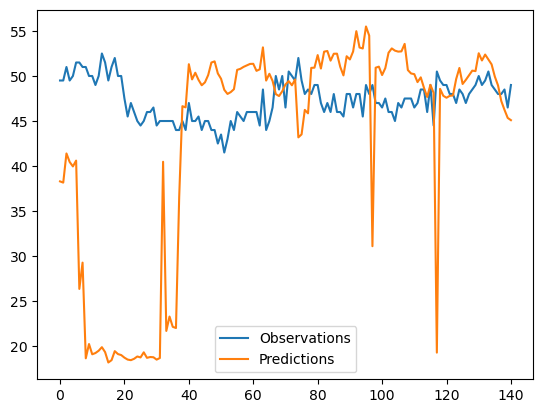

In [328]:
plt.plot(y2, label='Observations')
plt.plot(ytehat2, label='Predictions')
plt.legend()

# plt.plot(y1, label='Observations')
# plt.plot(ytrhat, label='Predictions')
# plt.legend()

In [329]:
excel_file_path = 'ENEOS_ADDA.xlsx'  # Specify the desired file path
df = pd.DataFrame(ytehat2)
df.to_excel(excel_file_path, index=False) 

In [330]:
MI1 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M1.txt',header=0,index_col=0,sep='\t')
MI2 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M2.txt',header=0,sep='\t')
MI3 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M3.txt',header=0,sep='\t')
MI1 = MI1.reset_index(drop=True)
print(MI1.shape, MI2.shape, MI3.shape)
MI2.drop(columns=MI2.columns[3],inplace=True)
raw_data = pd.concat([MI1.iloc[:,:12],MI2.iloc[:,:7],MI3.iloc[:,:9]],axis=1)
print(raw_data.shape)
raw_data.columns = ['f' + number for number in list(map(str,range(28)))] 
target = MI3.iloc[:,9].values
print(raw_data.shape)

(331, 13) (331, 9) (331, 10)
(331, 28)
(331, 28)


In [331]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.values, target, train_size=249,shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [361]:
source_data_loader = data_loader(X_train, y_train.reshape((-1,1)), batch_size=30, seed=0)
target_data_loader = data_loader(X_test, y_test.reshape((-1,1)), batch_size=20, seed=0)
feature_ex_s, reg = regressor(num_epochs=700, input_size=28, hidden_size=5, out_size=5, lr=0.0001, source_data_loader=source_data_loader)

feature_ex_t = Model_train(num_epochs=800, feature_ex=feature_ex_s, input_size=28, hidden_size=5, out_size=5, 
                           lr=0.0001, source_data_loader=source_data_loader,target_data_loader=target_data_loader)

Epoch [1/700] - loss: 0.3066
Epoch [2/700] - loss: 0.3023
Epoch [3/700] - loss: 0.2981
Epoch [4/700] - loss: 0.2942
Epoch [5/700] - loss: 0.2910
Epoch [6/700] - loss: 0.2879
Epoch [7/700] - loss: 0.2850
Epoch [8/700] - loss: 0.2821
Epoch [9/700] - loss: 0.2792
Epoch [100/700] - loss: 0.1806
Epoch [200/700] - loss: 0.0429
Epoch [300/700] - loss: 0.0039
Epoch [400/700] - loss: 0.0012
Epoch [500/700] - loss: 0.0008
Epoch [600/700] - loss: 0.0006
Epoch [700/700] - loss: 0.0005
Epoch [1/800] - Domain Loss: 0.4879 - Target Encoder Loss: 0.4741
Epoch [2/800] - Domain Loss: 0.4879 - Target Encoder Loss: 0.4741
Epoch [3/800] - Domain Loss: 0.4879 - Target Encoder Loss: 0.4741
Epoch [4/800] - Domain Loss: 0.4878 - Target Encoder Loss: 0.4741
Epoch [5/800] - Domain Loss: 0.4878 - Target Encoder Loss: 0.4741
Epoch [6/800] - Domain Loss: 0.4878 - Target Encoder Loss: 0.4741
Epoch [7/800] - Domain Loss: 0.4878 - Target Encoder Loss: 0.4741
Epoch [8/800] - Domain Loss: 0.4877 - Target Encoder Loss: 0

In [362]:
ytrhat = Model_eva(feature_ex_s, reg, source_data_loader)
ytehat = Model_eva(feature_ex_t, reg, target_data_loader)
print('Training RMSE:',rmse(y_train,ytrhat))
print('Training MAE:', mae(y_train,ytrhat))
print('Test2 RMSE:',rmse(y_test,ytehat))
print('Test2 MAE:',mae(y_test,ytehat))

Training RMSE: 0.07184691326927792
Training MAE: 0.044615459331499636
Test2 RMSE: 0.1762638112858072
Test2 MAE: 0.12038075108513419


In [363]:
excel_file_path = 'MI_ADDA.xlsx'  # Specify the desired file path
df = pd.DataFrame(ytehat)
df.to_excel(excel_file_path, index=False)  

In [364]:
df = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Penicillin Fermentation\IndPenSim_V3.csv')

# Exchange the column names 
df = df.rename(columns={'2-PAT control(PAT_ref:PAT ref)': 'Batch reference(Batch_ref:Batch ref)','Batch reference(Batch_ref:Batch ref)':'2-PAT control(PAT_ref:PAT ref)'})

# Fix the 4 hour delay by shifting 20 (20*12mins)
df['Offline Penicillin concentration(P_offline:P(g L^{-1}))'] = df['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].shift(-20)

In [365]:
# Split the data to variables and raman, the later is not useful
variable_raman_data = np.split(df, [df.columns.get_loc("2400")], axis=1)
variable_data = variable_raman_data[0]
raman_spectra = variable_raman_data[1]
delete_variables = ['Time (h)', '1- No Raman spec',' 1-Raman spec recorded',
                    'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
                    'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
                    'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
                    'Viscosity(Viscosity_offline:centPoise)',
                    '2-PAT control(PAT_ref:PAT ref)','Penicillin concentration(P:g/L)',
                    '0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)',
                    'Fault reference(Fault_ref:Fault ref)','Batch ID','Fault flag']
variable_data = variable_data.drop(delete_variables,axis=1)
# Group the data according to their batch number (1-100)
grouped_data = variable_data.groupby(['Batch reference(Batch_ref:Batch ref)'])

In [366]:
batch_id1, batch_id2 = 1, 19
batch1, batch2 = list(grouped_data)[batch_id1-1][1].iloc[:-20], list(grouped_data)[batch_id2-1][1].iloc[:-20]
offline_interp1 = batch1['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].interpolate(method='spline',order=3,limit=100, limit_direction='both')
offline_interp2 = batch2['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].interpolate(method='spline',order=3,limit=100, limit_direction='both')
y_train, y_test = offline_interp1.values, offline_interp2.values

In [367]:
X_train = batch1.drop(['Offline Penicillin concentration(P_offline:P(g L^{-1}))'],axis=1)
X_test = batch2.drop(['Offline Penicillin concentration(P_offline:P(g L^{-1}))'],axis=1)

# Drop inactive columns
irq = X_train.quantile(0.75)-X_train.quantile(0.25)
vars_inactive = irq.index[irq==0.0]
X_train = X_train.drop(vars_inactive,axis=1)
X_test = X_test[X_train.columns]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [435]:
source_data_loader = data_loader(X_train, y_train.reshape((-1,1)), batch_size=30, seed=0)
feature_ex_s, reg = regressor(num_epochs=800, input_size=20, hidden_size=5, out_size=5, lr=0.0001, source_data_loader=source_data_loader)

# source_data_loader = data_loader(X_train, y_train.reshape((-1,1)), batch_size=30, seed=0)
# target_data_loader = data_loader(X_test, y_test.reshape((-1,1)), batch_size=20, seed=0)
# feature_ex_t = Model_train(num_epochs=100, feature_ex=feature_ex_s, input_size=20, hidden_size=5, out_size=5, 
#                            lr=0.001, source_data_loader=source_data_loader,target_data_loader=target_data_loader)

Epoch [1/800] - loss: 877.5710
Epoch [2/800] - loss: 876.9074
Epoch [3/800] - loss: 876.2836
Epoch [4/800] - loss: 875.6864
Epoch [5/800] - loss: 875.1037
Epoch [6/800] - loss: 874.5341
Epoch [7/800] - loss: 873.9762
Epoch [8/800] - loss: 873.4328
Epoch [9/800] - loss: 872.8894
Epoch [100/800] - loss: 748.6927
Epoch [200/800] - loss: 487.3008
Epoch [300/800] - loss: 245.0223
Epoch [400/800] - loss: 118.1456
Epoch [500/800] - loss: 69.2406
Epoch [600/800] - loss: 47.7575
Epoch [700/800] - loss: 36.8140
Epoch [800/800] - loss: 30.5077


In [436]:
ytrhat = Model_eva(feature_ex_s, reg, source_data_loader)
ytehat = Model_eva(feature_ex_s, reg, target_data_loader)
print('Training RMSE:',rmse(y_train,ytrhat))
print('Training MAE:', mae(y_train,ytrhat))
print('Test2 RMSE:',rmse(y_test,ytehat))
print('Test2 MAE:',mae(y_test,ytehat))

Training RMSE: 3.1393301484350458
Training MAE: 2.3542205630146635
Test2 RMSE: 10.236032537439954
Test2 MAE: 7.176660146015477


In [ ]:
excel_file_path = 'P_ADDA.xlsx'  # Specify the desired file path
df = pd.DataFrame(ytehat)
df.to_excel(excel_file_path, index=False)  